<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work attempts to provide a comprehensive exploration of neural network quantisation, the process of reducing the numerical precision of weights and activations to enable faster inference and smaller model sizes. I begin with the mathematical foundations of quantization: how continuous values map to discrete representations, the sources of quantization error, and the trade-offs between precision and efficiency. I then implement key quantisation schemes from scratch, including uniform affine quantization, symmetric quantization, and per-channel quantization. The experimental framework demonstrates both post-training quantization (PTQ) and quantization-aware training (QAT) on MNIST, measuring the accuracy-efficiency trade-off across different bit-widths (8-bit, 4-bit, 2-bit). The analysis connects quantization theory to broader research themes including model compression for edge deployment, knowledge distillation (where quantized students learn from full-precision teachers), and efficient inference for the CompressML platform.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Union
from dataclasses import dataclass
from copy import deepcopy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
class QuantizationConfig:
    """
    Configuration for quantization parameters.

    Encapsulates all the choices involved in a quantization scheme:
    bit-width, symmetric vs asymmetric, per-tensor vs per-channel, etc.
    """

    def __init__(
        self,
        bits: int = 8,
        symmetric: bool = True,
        per_channel: bool = False,
        channel_axis: int = 0
    ):

        self.bits = bits
        self.symmetric = symmetric
        self.per_channel = per_channel
        self.channel_axis = channel_axis

        # Compute quantization range
        if symmetric:
            # Symmetric: [-2^(b-1)+1, 2^(b-1)-1] to keep zero at zero
            self.q_min = -(2 ** (bits - 1)) + 1
            self.q_max = (2 ** (bits - 1)) - 1
        else:
            # Asymmetric: [0, 2^b - 1]
            self.q_min = 0
            self.q_max = (2 ** bits) - 1

    def __repr__(self):
        return (f"QuantConfig(bits={self.bits}, symmetric={self.symmetric}, "
                f"per_channel={self.per_channel}, range=[{self.q_min}, {self.q_max}])")

In [3]:
def compute_quantization_params(
    tensor: torch.Tensor,
    config: QuantizationConfig
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute scale and zero_point for quantizing a tensor.

    This is the core calibration function. Given a tensor and config,
    determine the optimal quantization parameters.

    Args:
        tensor: Tensor to compute parameters for (weights or activations)
        config: Quantization configuration

    Returns:
        Tuple of (scale, zero_point) tensors
    """
    if config.per_channel:
        # Compute min/max per channel
        # Reshape to (num_channels, -1) then take min/max
        axis = config.channel_axis
        num_channels = tensor.shape[axis]

        # Move channel axis to front, flatten rest
        permute_dims = [axis] + [i for i in range(tensor.dim()) if i != axis]
        tensor_permuted = tensor.permute(permute_dims).reshape(num_channels, -1)

        x_min = tensor_permuted.min(dim=1)[0]
        x_max = tensor_permuted.max(dim=1)[0]
    else:
        # Per-tensor: single min/max
        x_min = tensor.min()
        x_max = tensor.max()

    if config.symmetric:
        # Symmetric: scale based on max absolute value
        x_abs_max = torch.maximum(x_min.abs(), x_max.abs())
        scale = x_abs_max / config.q_max
        zero_point = torch.zeros_like(scale)
    else:
        # Asymmetric: use full range
        scale = (x_max - x_min) / (config.q_max - config.q_min)
        zero_point = config.q_min - torch.round(x_min / scale)
        zero_point = torch.clamp(zero_point, config.q_min, config.q_max)

    # Avoid division by zero
    scale = torch.clamp(scale, min=1e-8)

    return scale, zero_point

In [4]:
def quantize_tensor(
    tensor: torch.Tensor,
    scale: torch.Tensor,
    zero_point: torch.Tensor,
    config: QuantizationConfig
) -> torch.Tensor:
    """
    Quantize a tensor to integers.

    Args:
        tensor: Float tensor to quantize
        scale: Quantization scale
        zero_point: Quantization zero point
        config: Quantization configuration

    Returns:
        Quantized integer tensor
    """
    if config.per_channel:
        # Reshape scale/zero_point for broadcasting
        shape = [1] * tensor.dim()
        shape[config.channel_axis] = -1
        scale = scale.reshape(shape)
        zero_point = zero_point.reshape(shape)

    # Quantize: q = round(x / scale) + zero_point
    q = torch.round(tensor / scale) + zero_point
    q = torch.clamp(q, config.q_min, config.q_max)

    return q


def dequantize_tensor(
    q_tensor: torch.Tensor,
    scale: torch.Tensor,
    zero_point: torch.Tensor,
    config: QuantizationConfig
) -> torch.Tensor:
    """
    Dequantize integers back to floats.

    Args:
        q_tensor: Quantized integer tensor
        scale: Quantization scale
        zero_point: Quantization zero point
        config: Quantization configuration

    Returns:
        Dequantized float tensor
    """
    if config.per_channel:
        shape = [1] * q_tensor.dim()
        shape[config.channel_axis] = -1
        scale = scale.reshape(shape)
        zero_point = zero_point.reshape(shape)

    # Dequantize: x = (q - zero_point) * scale
    return (q_tensor - zero_point) * scale

In [5]:
def fake_quantize(
    tensor: torch.Tensor,
    scale: torch.Tensor,
    zero_point: torch.Tensor,
    config: QuantizationConfig
) -> torch.Tensor:
    """
    Fake quantization: quantize then immediately dequantize.

    This simulates quantization error while keeping values in float.
    Used during QAT to train networks that are robust to quantization.

    Args:
        tensor: Float tensor
        scale: Quantization scale
        zero_point: Quantization zero point
        config: Quantization configuration

    Returns:
        Fake-quantized float tensor (has quantization error but is still float)
    """
    q = quantize_tensor(tensor, scale, zero_point, config)
    return dequantize_tensor(q, scale, zero_point, config)

In [6]:
class StraightThroughEstimator(torch.autograd.Function):
    """
    Straight-Through Estimator for quantization gradients.

    The quantization function (round + clamp) has zero gradient almost everywhere.
    STE passes gradients through unchanged, pretending quantization is identity.

    This is a hack, but it works remarkably well in practice.
    """

    @staticmethod
    def forward(ctx, tensor, scale, zero_point, config):
        # Save for potential use in backward (not used here)
        ctx.save_for_backward(tensor)
        return fake_quantize(tensor, scale, zero_point, config)

    @staticmethod
    def backward(ctx, grad_output):
        # Pass gradient through unchanged
        # Return None for scale, zero_point, config (non-tensor args)
        return grad_output, None, None, None


def fake_quantize_ste(
    tensor: torch.Tensor,
    scale: torch.Tensor,
    zero_point: torch.Tensor,
    config: QuantizationConfig
) -> torch.Tensor:
    """
    Fake quantization with straight-through estimator for gradients.

    Use this during QAT training.
    """
    return StraightThroughEstimator.apply(tensor, scale, zero_point, config)

In [7]:
class QuantizedLinear(nn.Module):
    """
    Linear layer with quantization support.

    Can operate in three modes:
    - float: Standard FP32 operation (for training baseline)
    - calibration: Collect activation statistics
    - quantized: Apply quantization (PTQ or QAT)

    Supports both post-training quantization and quantization-aware training.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        weight_config: Optional[QuantizationConfig] = None,
        activation_config: Optional[QuantizationConfig] = None
    ):
        """
        Args:
            in_features: Input dimension
            out_features: Output dimension
            bias: Whether to include bias
            weight_config: Quantization config for weights (None = no quantization)
            activation_config: Quantization config for activations
        """
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Standard linear layer parameters
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)

        # Quantization configs
        self.weight_config = weight_config
        self.activation_config = activation_config

        # Quantization parameters (computed during calibration)
        self.register_buffer('weight_scale', None)
        self.register_buffer('weight_zero_point', None)
        self.register_buffer('input_scale', None)
        self.register_buffer('input_zero_point', None)

        # For calibration: track running min/max
        self.register_buffer('running_min', None)
        self.register_buffer('running_max', None)

        # Mode: 'float', 'calibration', 'quantized'
        self.mode = 'float'

        # QAT flag
        self.qat = False

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        """Initialize with Kaiming uniform."""
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in = self.weight.size(1)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def set_mode(self, mode: str):
        """Set operation mode."""
        assert mode in ['float', 'calibration', 'quantized']
        self.mode = mode

        if mode == 'calibration':
            self.running_min = None
            self.running_max = None

    def enable_qat(self, enable: bool = True):
        """Enable/disable quantization-aware training."""
        self.qat = enable

    def calibrate_weights(self):
        """Compute quantization parameters for weights."""
        if self.weight_config is not None:
            scale, zp = compute_quantization_params(self.weight.data, self.weight_config)
            self.weight_scale = scale
            self.weight_zero_point = zp

    def calibrate_activations(self):
        """Compute quantization parameters for activations from collected stats."""
        if self.activation_config is not None and self.running_min is not None:
            # Create a dummy tensor with the observed range
            # .item() is used to extract scalar values from the single-element tensors
            dummy = torch.tensor([self.running_min.item(), self.running_max.item()],
                                 device=self.weight.device)
            scale, zp = compute_quantization_params(dummy, self.activation_config)
            self.input_scale = scale
            self.input_zero_point = zp

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with optional quantization.
        """
        if self.mode == 'float':
            # Standard FP32 forward
            return F.linear(x, self.weight, self.bias)

        elif self.mode == 'calibration':
            # Track activation statistics
            with torch.no_grad():
                current_min = x.min()
                current_max = x.max()
                if self.running_min is None:
                    self.running_min = current_min # Store as tensor
                    self.running_max = current_max # Store as tensor
                else:
                    self.running_min = torch.min(self.running_min, current_min)
                    self.running_max = torch.max(self.running_max, current_max)

            return F.linear(x, self.weight, self.bias)

        elif self.mode == 'quantized':
            # Apply quantization
            w = self.weight

            # Quantize weights
            if self.weight_config is not None and self.weight_scale is not None:
                if self.qat and self.training:
                    # QAT: use STE for gradients
                    w = fake_quantize_ste(w, self.weight_scale,
                                          self.weight_zero_point, self.weight_config)
                else:
                    # PTQ or inference: standard fake quantize
                    w = fake_quantize(w, self.weight_scale,
                                      self.weight_zero_point, self.weight_config)

            # Quantize input activations
            if self.activation_config is not None and self.input_scale is not None:
                if self.qat and self.training:
                    x = fake_quantize_ste(x, self.input_scale,
                                          self.input_zero_point, self.activation_config)
                else:
                    x = fake_quantize(x, self.input_scale,
                                      self.input_zero_point, self.activation_config)

            return F.linear(x, w, self.bias)

    def extra_repr(self) -> str:
        return (f'in_features={self.in_features}, out_features={self.out_features}, '
                f'bias={self.bias is not None}, mode={self.mode}')

In [8]:
class QuantizedModel(nn.Module):
    """
    Simple MLP with quantization support for MNIST classification.

    This serves as our testbed for comparing PTQ and QAT approaches
    across different bit-widths.
    """

    def __init__(
        self,
        input_dim: int = 784,
        hidden_dims: List[int] = [256, 128],
        output_dim: int = 10,
        weight_bits: Optional[int] = None,
        activation_bits: Optional[int] = None
    ):
        """
        Args:
            input_dim: Input dimension
            hidden_dims: List of hidden layer dimensions
            output_dim: Output dimension
            weight_bits: Bit-width for weight quantization (None = no quantization)
            activation_bits: Bit-width for activation quantization
        """
        super().__init__()

        # Create quantization configs
        weight_config = None
        activation_config = None

        if weight_bits is not None:
            weight_config = QuantizationConfig(
                bits=weight_bits,
                symmetric=True,
                per_channel=True,
                channel_axis=0
            )

        if activation_bits is not None:
            activation_config = QuantizationConfig(
                bits=activation_bits,
                symmetric=False,  # Activations after ReLU are non-negative
                per_channel=False
            )

        # Build layers
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(QuantizedLinear(
                prev_dim, hidden_dim,
                weight_config=weight_config,
                activation_config=activation_config
            ))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer (typically not quantized as heavily)
        layers.append(QuantizedLinear(
            prev_dim, output_dim,
            weight_config=weight_config,
            activation_config=None  # Don't quantize final logits
        ))

        self.layers = nn.Sequential(*layers)
        self.weight_bits = weight_bits
        self.activation_bits = activation_bits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def set_mode(self, mode: str):
        """Set mode for all quantized layers."""
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.set_mode(mode)

    def enable_qat(self, enable: bool = True):
        """Enable QAT for all quantized layers."""
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.enable_qat(enable)

    def calibrate(self, dataloader: DataLoader, num_batches: int = 10):
        """
        Calibrate quantization parameters using representative data.

        Args:
            dataloader: DataLoader with calibration data
            num_batches: Number of batches to use for calibration
        """
        self.eval()
        self.set_mode('calibration')

        with torch.no_grad():
            for i, (data, _) in enumerate(dataloader):
                if i >= num_batches:
                    break
                data = data.to(next(self.parameters()).device)
                self(data)

        # Compute quantization parameters from collected statistics
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.calibrate_weights()
                module.calibrate_activations()

        self.set_mode('quantized')

    def get_model_size(self) -> Dict[str, float]:
        """
        Calculate model size in different precisions.

        Returns:
            Dict with fp32_mb, quantized_mb, compression_ratio
        """
        total_params = sum(p.numel() for p in self.parameters())
        fp32_bytes = total_params * 4  # 4 bytes per FP32

        if self.weight_bits is not None:
            quant_bytes = total_params * self.weight_bits / 8
        else:
            quant_bytes = fp32_bytes

        return {
            'fp32_mb': fp32_bytes / (1024 * 1024),
            'quantized_mb': quant_bytes / (1024 * 1024),
            'compression_ratio': fp32_bytes / quant_bytes if quant_bytes > 0 else 1.0
        }

In [9]:
# Verify quantization implementation

print("Testing quantization implementation...\n")

# Test tensor
x = torch.randn(100) * 2 - 0.5  # Range roughly [-2.5, 1.5]

for bits in [8, 4, 2]:
    config = QuantizationConfig(bits=bits, symmetric=False)
    scale, zp = compute_quantization_params(x, config)
    x_quant = quantize_tensor(x, scale, zp, config)
    x_dequant = dequantize_tensor(x_quant, scale, zp, config)

    error = (x - x_dequant).abs().mean()
    max_error = (x - x_dequant).abs().max()

    print(f"{bits}-bit quantization:")
    print(f"  Scale: {scale.item():.6f}")
    print(f"  Zero point: {zp.item():.0f}")
    print(f"  Mean error: {error.item():.6f}")
    print(f"  Max error: {max_error.item():.6f}")
    print(f"  Unique values: {len(x_quant.unique())} (max {2**bits})")
    print()

Testing quantization implementation...

8-bit quantization:
  Scale: 0.041761
  Zero point: 110
  Mean error: 0.010530
  Max error: 0.020769
  Unique values: 76 (max 256)

4-bit quantization:
  Scale: 0.709934
  Zero point: 6
  Mean error: 0.178507
  Max error: 0.353129
  Unique values: 13 (max 16)

2-bit quantization:
  Scale: 3.549670
  Zero point: 1
  Mean error: 0.927909
  Max error: 1.772997
  Unique values: 4 (max 4)



PTQ quantizes a pre-trained FP32 model without any retraining. It's fast and simple but loses accuracy at lower bit-widths.

In [10]:
# Data loading

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Small calibration set
calib_dataset = Subset(train_dataset, range(1000))
calib_loader = DataLoader(calib_dataset, batch_size=100, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Calibration samples: {len(calib_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 132MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 35.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 131MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]


Train samples: 60000
Test samples: 10000
Calibration samples: 1000


In [11]:
def train_model(model, train_loader, epochs=5, lr=0.001):
    """
    Train a model on MNIST.
    """
    model.train()
    model.set_mode('float')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        print(f"Epoch {epoch+1}/{epochs}: Loss={total_loss/total:.4f}, Acc={100*correct/total:.2f}%")

    return model


def evaluate_model(model, test_loader, mode='float'):
    """
    Evaluate model accuracy.
    """
    model.eval()
    model.set_mode(mode)

    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

    return correct / total

In [ ]:
# Experiment 1: Post-Training Quantization at different bit-widths

print("=" * 70)
print("EXPERIMENT 1: Post-Training Quantization")
print("=" * 70)
print("\nTraining FP32 baseline, then quantizing to 8/4/2 bits.\n")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train FP32 baseline
print("Training FP32 baseline...")
baseline_model = QuantizedModel(
    hidden_dims=[256, 128],
    weight_bits=None,
    activation_bits=None
).to(device)

baseline_model = train_model(baseline_model, train_loader, epochs=5)
baseline_acc = evaluate_model(baseline_model, test_loader, mode='float')
print(f"\nFP32 Baseline Accuracy: {100*baseline_acc:.2f}%")

# Save baseline weights
baseline_state = deepcopy(baseline_model.state_dict())

EXPERIMENT 1: Post-Training Quantization

Training FP32 baseline, then quantizing to 8/4/2 bits.

Training FP32 baseline...
Epoch 1/5: Loss=0.2633, Acc=92.20%
Epoch 2/5: Loss=0.1004, Acc=96.92%
Epoch 3/5: Loss=0.0664, Acc=97.91%
Epoch 4/5: Loss=0.0499, Acc=98.37%


In [ ]:
# PTQ at different bit-widths

ptq_results = {}

for bits in [8, 4, 2]:
    print(f"\n{'='*50}")
    print(f"PTQ {bits}-bit quantization")
    print('='*50)

    # Create quantized model and load FP32 weights
    model = QuantizedModel(
        hidden_dims=[256, 128],
        weight_bits=bits,
        activation_bits=bits
    ).to(device)

    # Copy weights from baseline (only matching keys)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in baseline_state.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Calibrate
    print("Calibrating...")
    model.calibrate(calib_loader, num_batches=10)

    # Evaluate
    quant_acc = evaluate_model(model, test_loader, mode='quantized')
    size_info = model.get_model_size()

    ptq_results[bits] = {
        'accuracy': quant_acc,
        'size_mb': size_info['quantized_mb'],
        'compression': size_info['compression_ratio']
    }

    print(f"\n{bits}-bit PTQ Results:")
    print(f"  Accuracy: {100*quant_acc:.2f}% (drop: {100*(baseline_acc - quant_acc):.2f}%)")
    print(f"  Model size: {size_info['quantized_mb']:.3f} MB")
    print(f"  Compression: {size_info['compression_ratio']:.1f}x")

Quantization-Aware Training
QAT trains with simulated quantization, allowing the network to learn weights that are robust to quantization error.

In [ ]:
def train_qat(model, train_loader, epochs=5, lr=0.0001):
    """
    Quantization-Aware Training.

    Trains with fake quantization in the forward pass, using straight-through
    estimator for gradients.
    """
    model.train()
    model.set_mode('quantized')
    model.enable_qat(True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            # Re-calibrate weights after update (they changed!)
            for module in model.modules():
                if isinstance(module, QuantizedLinear):
                    module.calibrate_weights()

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)

        print(f"Epoch {epoch+1}/{epochs}: Loss={total_loss/total:.4f}, Acc={100*correct/total:.2f}%")

    model.enable_qat(False)
    return model

In [15]:
# Experiment 2: Quantization-Aware Training

print("\n" + "=" * 70)
print("EXPERIMENT 2: Quantization-Aware Training")
print("=" * 70)
print("\nFine-tuning with simulated quantization at different bit-widths.\n")

qat_results = {}

for bits in [8, 4, 2]:
    print(f"\n{'='*50}")
    print(f"QAT {bits}-bit training")
    print('='*50)

    # Create model and load FP32 weights
    model = QuantizedModel(
        hidden_dims=[256, 128],
        weight_bits=bits,
        activation_bits=bits
    ).to(device)

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in baseline_state.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Initial calibration
    model.calibrate(calib_loader, num_batches=10)

    # QAT fine-tuning
    print("\nQAT fine-tuning...")
    model = train_qat(model, train_loader, epochs=3, lr=0.0001)

    # Evaluate
    qat_acc = evaluate_model(model, test_loader, mode='quantized')
    size_info = model.get_model_size()

    qat_results[bits] = {
        'accuracy': qat_acc,
        'size_mb': size_info['quantized_mb'],
        'compression': size_info['compression_ratio']
    }

    print(f"\n{bits}-bit QAT Results:")
    print(f"  Accuracy: {100*qat_acc:.2f}% (drop: {100*(baseline_acc - qat_acc):.2f}%)")
    print(f"  PTQ was: {100*ptq_results[bits]['accuracy']:.2f}%")
    print(f"  Improvement from QAT: {100*(qat_acc - ptq_results[bits]['accuracy']):.2f}%")


EXPERIMENT 2: Quantization-Aware Training

Fine-tuning with simulated quantization at different bit-widths.


QAT 8-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.0148, Acc=99.59%
Epoch 2/3: Loss=0.0103, Acc=99.77%
Epoch 3/3: Loss=0.0082, Acc=99.83%

8-bit QAT Results:
  Accuracy: 98.45% (drop: -0.58%)
  PTQ was: 97.84%
  Improvement from QAT: 0.61%

QAT 4-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.0176, Acc=99.50%
Epoch 2/3: Loss=0.0128, Acc=99.66%
Epoch 3/3: Loss=0.0104, Acc=99.73%

4-bit QAT Results:
  Accuracy: 98.20% (drop: -0.33%)
  PTQ was: 97.69%
  Improvement from QAT: 0.51%

QAT 2-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.8972, Acc=68.56%
Epoch 2/3: Loss=0.3067, Acc=90.30%
Epoch 3/3: Loss=0.2375, Acc=92.50%

2-bit QAT Results:
  Accuracy: 93.05% (drop: 4.82%)
  PTQ was: 22.07%
  Improvement from QAT: 70.98%



RESULTS SUMMARY


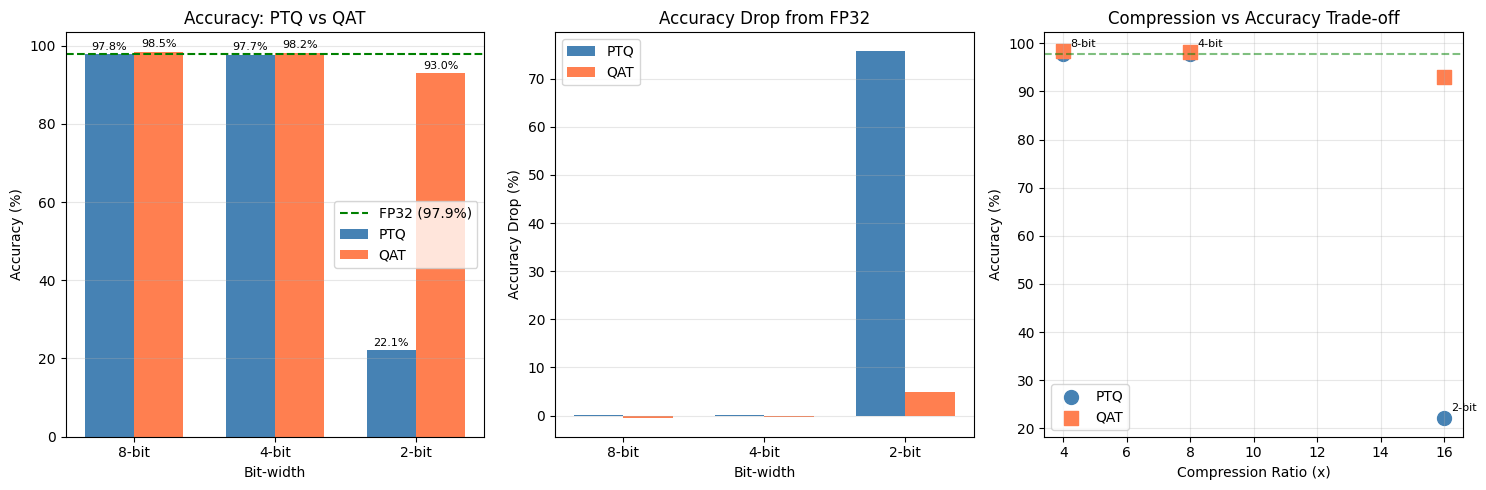

In [16]:
# Comprehensive comparison visualization

print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

bits_list = [8, 4, 2]
x = np.arange(len(bits_list))
width = 0.35

# Plot 1: Accuracy comparison
ax = axes[0]
ptq_accs = [ptq_results[b]['accuracy'] * 100 for b in bits_list]
qat_accs = [qat_results[b]['accuracy'] * 100 for b in bits_list]

bars1 = ax.bar(x - width/2, ptq_accs, width, label='PTQ', color='steelblue')
bars2 = ax.bar(x + width/2, qat_accs, width, label='QAT', color='coral')
ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', label=f'FP32 ({baseline_acc*100:.1f}%)')

ax.set_xlabel('Bit-width')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy: PTQ vs QAT')
ax.set_xticks(x)
ax.set_xticklabels([f'{b}-bit' for b in bits_list])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

# Plot 2: Accuracy drop
ax = axes[1]
ptq_drops = [(baseline_acc - ptq_results[b]['accuracy']) * 100 for b in bits_list]
qat_drops = [(baseline_acc - qat_results[b]['accuracy']) * 100 for b in bits_list]

ax.bar(x - width/2, ptq_drops, width, label='PTQ', color='steelblue')
ax.bar(x + width/2, qat_drops, width, label='QAT', color='coral')

ax.set_xlabel('Bit-width')
ax.set_ylabel('Accuracy Drop (%)')
ax.set_title('Accuracy Drop from FP32')
ax.set_xticks(x)
ax.set_xticklabels([f'{b}-bit' for b in bits_list])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Compression vs Accuracy trade-off
ax = axes[2]
compressions = [32/b for b in bits_list]  # Compression ratio

ax.scatter(compressions, ptq_accs, s=100, label='PTQ', marker='o', color='steelblue')
ax.scatter(compressions, qat_accs, s=100, label='QAT', marker='s', color='coral')
ax.axhline(y=baseline_acc * 100, color='green', linestyle='--', alpha=0.5)

for i, bits in enumerate(bits_list):
    ax.annotate(f'{bits}-bit', (compressions[i], ptq_accs[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Compression Ratio (x)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Compression vs Accuracy Trade-off')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('quantization_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Experiment 2: Quantization-Aware Training

print("\n" + "=" * 70)
print("EXPERIMENT 2: Quantization-Aware Training")
print("=" * 70)
print("\nFine-tuning with simulated quantization at different bit-widths.\n")

qat_results = {}

for bits in [8, 4, 2]:
    print(f"\n{'='*50}")
    print(f"QAT {bits}-bit training")
    print('='*50)

    # Create model and load FP32 weights
    model = QuantizedModel(
        hidden_dims=[256, 128],
        weight_bits=bits,
        activation_bits=bits
    ).to(device)

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in baseline_state.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Initial calibration
    model.calibrate(calib_loader, num_batches=10)

    # QAT fine-tuning
    print("\nQAT fine-tuning...")
    model = train_qat(model, train_loader, epochs=3, lr=0.0001)

    # Evaluate
    qat_acc = evaluate_model(model, test_loader, mode='quantized')
    size_info = model.get_model_size()

    qat_results[bits] = {
        'accuracy': qat_acc,
        'size_mb': size_info['quantized_mb'],
        'compression': size_info['compression_ratio']
    }

    print(f"\n{bits}-bit QAT Results:")
    print(f"  Accuracy: {100*qat_acc:.2f}% (drop: {100*(baseline_acc - qat_acc):.2f}%)")
    print(f"  PTQ was: {100*ptq_results[bits]['accuracy']:.2f}%")
    print(f"  Improvement from QAT: {100*(qat_acc - ptq_results[bits]['accuracy']):.2f}%")


EXPERIMENT 2: Quantization-Aware Training

Fine-tuning with simulated quantization at different bit-widths.


QAT 8-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.0147, Acc=99.62%
Epoch 2/3: Loss=0.0102, Acc=99.78%
Epoch 3/3: Loss=0.0080, Acc=99.84%

8-bit QAT Results:
  Accuracy: 98.35% (drop: -0.48%)
  PTQ was: 97.84%
  Improvement from QAT: 0.51%

QAT 4-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.0176, Acc=99.48%
Epoch 2/3: Loss=0.0123, Acc=99.68%
Epoch 3/3: Loss=0.0106, Acc=99.73%

4-bit QAT Results:
  Accuracy: 98.29% (drop: -0.42%)
  PTQ was: 97.69%
  Improvement from QAT: 0.60%

QAT 2-bit training

QAT fine-tuning...
Epoch 1/3: Loss=0.8911, Acc=68.93%


In [ ]:
# Experiment 3: Weight distribution analysis

print("\n" + "=" * 70)
print("EXPERIMENT 3: Weight Distribution Analysis")
print("=" * 70)
print("\nVisualizing how quantization affects weight distributions.\n")

# Get original weights from baseline
original_weights = []
for name, param in baseline_model.named_parameters():
    if 'weight' in name:
        original_weights.append(param.data.cpu().flatten().numpy())

all_weights = np.concatenate(original_weights)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original FP32 distribution
ax = axes[0, 0]
ax.hist(all_weights, bins=100, density=True, alpha=0.7, color='green')
ax.set_xlabel('Weight Value')
ax.set_ylabel('Density')
ax.set_title('FP32 Weight Distribution')
ax.grid(True, alpha=0.3)

# Quantized distributions
for idx, bits in enumerate([8, 4, 2]):
    ax = axes[(idx + 1) // 2, (idx + 1) % 2]

    # Quantize and dequantize
    config = QuantizationConfig(bits=bits, symmetric=True)
    tensor = torch.tensor(all_weights)
    scale, zp = compute_quantization_params(tensor, config)
    q = quantize_tensor(tensor, scale, zp, config)
    dq = dequantize_tensor(q, scale, zp, config).numpy()

    ax.hist(dq, bins=2**bits, density=True, alpha=0.7, color=f'C{idx}')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.set_title(f'{bits}-bit Quantized ({2**bits} levels)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('weight_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Experiment 4: Layer-wise quantization sensitivity

print("\n" + "=" * 70)
print("EXPERIMENT 4: Layer-wise Sensitivity Analysis")
print("=" * 70)
print("\nWhich layers are most sensitive to quantization?\n")

def evaluate_with_layer_quantized(model_state, layer_idx, bits, test_loader):
    """
    Evaluate model with only one layer quantized.
    """
    # Create model where only one layer is quantized
    model = QuantizedModel(
        hidden_dims=[256, 128],
        weight_bits=None,
        activation_bits=None
    ).to(device)

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in model_state.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Find the target layer and quantize only that one
    quant_layers = [m for m in model.modules() if isinstance(m, QuantizedLinear)]
    target_layer = quant_layers[layer_idx]

    # Manually quantize this layer's weights
    config = QuantizationConfig(bits=bits, symmetric=True, per_channel=True)
    scale, zp = compute_quantization_params(target_layer.weight.data, config)
    target_layer.weight.data = fake_quantize(target_layer.weight.data, scale, zp, config)

    # Evaluate
    return evaluate_model(model, test_loader, mode='float')


layer_names = ['Layer 1 (784→256)', 'Layer 2 (256→128)', 'Layer 3 (128→10)']
sensitivity_results = {}

for bits in [8, 4, 2]:
    print(f"\n{bits}-bit sensitivity:")
    drops = []

    for layer_idx in range(3):
        acc = evaluate_with_layer_quantized(baseline_state, layer_idx, bits, test_loader)
        drop = (baseline_acc - acc) * 100
        drops.append(drop)
        print(f"  {layer_names[layer_idx]}: {100*acc:.2f}% (drop: {drop:.2f}%)")

    sensitivity_results[bits] = drops


EXPERIMENT 4: Layer-wise Sensitivity Analysis

Which layers are most sensitive to quantization?


8-bit sensitivity:
  Layer 1 (784→256): 97.88% (drop: -0.01%)
  Layer 2 (256→128): 97.87% (drop: 0.00%)
  Layer 3 (128→10): 97.88% (drop: -0.01%)

4-bit sensitivity:
  Layer 1 (784→256): 97.77% (drop: 0.10%)
  Layer 2 (256→128): 97.83% (drop: 0.04%)
  Layer 3 (128→10): 97.84% (drop: 0.03%)

2-bit sensitivity:
  Layer 1 (784→256): 94.49% (drop: 3.38%)
  Layer 2 (256→128): 95.24% (drop: 2.63%)
  Layer 3 (128→10): 78.61% (drop: 19.26%)


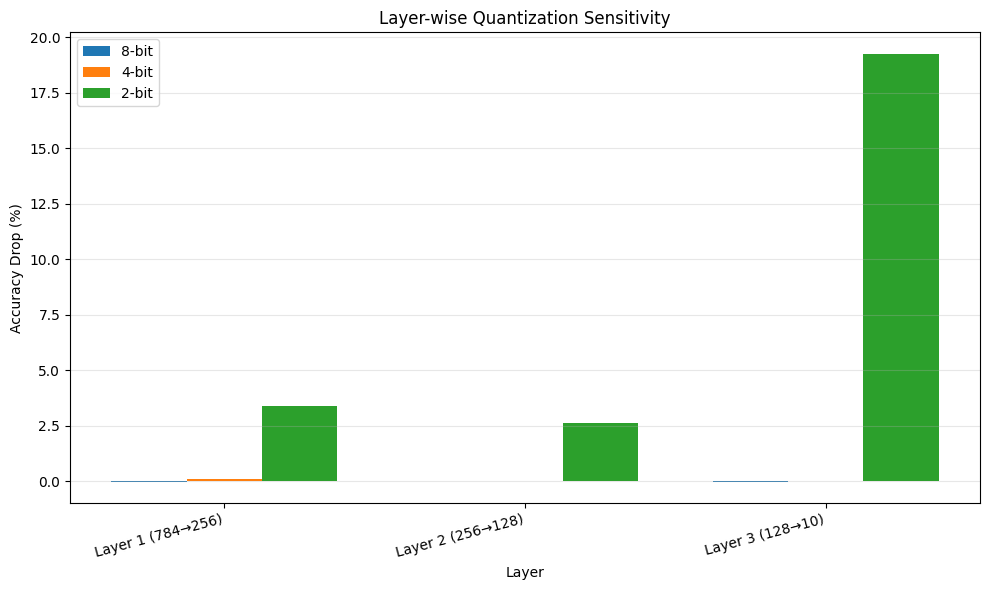

In [20]:
# Visualize layer sensitivity

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(layer_names))
width = 0.25

for i, bits in enumerate([8, 4, 2]):
    drops = sensitivity_results[bits]
    ax.bar(x + i * width, drops, width, label=f'{bits}-bit')

ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy Drop (%)')
ax.set_title('Layer-wise Quantization Sensitivity')
ax.set_xticks(x + width)
ax.set_xticklabels(layer_names, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('layer_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Experiment 5: Quantization error propagation

print("\n" + "=" * 70)
print("EXPERIMENT 5: Quantization Error Propagation")
print("=" * 70)
print("\nHow does quantization error accumulate through layers?\n")

def measure_layer_errors(model, data_batch, bits):
    """
    Measure quantization error at each layer.
    """
    model.eval()

    # Get FP32 activations
    model.set_mode('float')
    fp32_activations = []

    x = data_batch.view(data_batch.size(0), -1)
    for module in model.layers:
        x = module(x)
        if isinstance(module, QuantizedLinear):
            fp32_activations.append(x.clone())

    # Get quantized activations
    model.calibrate(DataLoader([(data_batch, torch.zeros(data_batch.size(0)))], batch_size=data_batch.size(0)), num_batches=1)
    model.set_mode('quantized')
    quant_activations = []

    x = data_batch.view(data_batch.size(0), -1)
    for module in model.layers:
        x = module(x)
        if isinstance(module, QuantizedLinear):
            quant_activations.append(x.clone())

    # Compute errors
    errors = []
    for fp32, quant in zip(fp32_activations, quant_activations):
        mse = ((fp32 - quant) ** 2).mean().item()
        rel_error = (torch.abs(fp32 - quant) / (torch.abs(fp32) + 1e-8)).mean().item()
        errors.append({'mse': mse, 'rel_error': rel_error * 100})

    return errors


# Get a test batch
test_batch, _ = next(iter(test_loader))
test_batch = test_batch[:100].to(device)

error_results = {}

for bits in [8, 4, 2]:
    model = QuantizedModel(
        hidden_dims=[256, 128],
        weight_bits=bits,
        activation_bits=bits
    ).to(device)

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in baseline_state.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    errors = measure_layer_errors(model, test_batch, bits)
    error_results[bits] = errors

    print(f"\n{bits}-bit layer errors:")
    for i, err in enumerate(errors):
        print(f"  {layer_names[i]}: MSE={err['mse']:.6f}, RelErr={err['rel_error']:.2f}%")